
# Collaboratif filtering throw matrix factorization (users matrix)


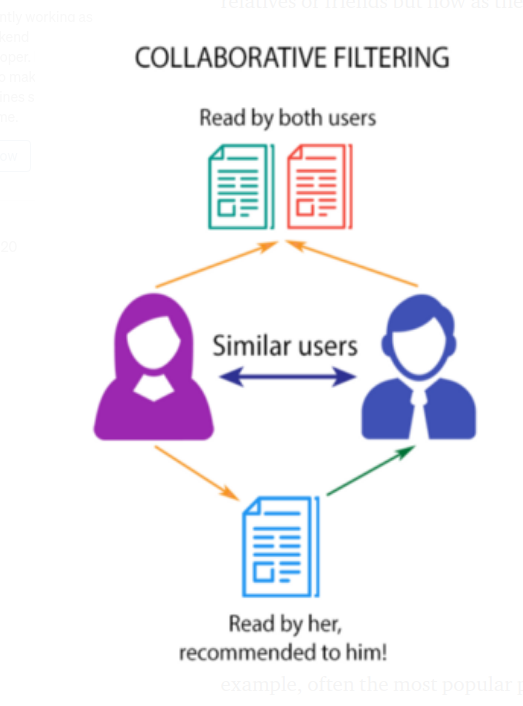

In [12]:
from IPython.display import Image
Image("../imgs/collaboratif_filtring.png")


In [9]:
import torch
from scipy.spatial.distance import cdist
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from utils import load_data
import numpy as np

# The data

First, let's load some data.

In [4]:
users,movies,ratings = load_data()
nb_users = users.shape[0]
print("Users shape",users.shape)
print("Movies shape",movies.shape)
print("ratings shape",ratings.shape)

Users shape (6040, 5)
Movies shape (3883, 21)
ratings shape (1000209, 3)


In [5]:
users.head()

,user_id,gender,age,occupation,zip_code
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455


In [6]:
ratings.head()

,user_id,movie_id,rating
0,0,1176,5
1,0,655,3
2,0,902,3
3,0,3339,4
4,0,2286,5


In [7]:
movies.head()

,movie_id,title,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0,Toy Story,1995,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Jumanji,1995,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Grumpier Old Men,1995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Waiting to Exhale,1995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Father of the Bride Part II,1995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
ratings.iloc[0]

user_id        0
movie_id    1176
rating         5
Name: 0, dtype: int64

## Building the ratings matrix

In [11]:
nbUsers = len(users)
nbMovies = max(np.unique(movies["movie_id"]))+1
ratingsMatrix = np.zeros((nbUsers,nbMovies))

for i in range(len(ratings)):
    if i%100000 == 0:
        print(i)
    row = ratings.iloc[i]
    userid = int(row["user_id"])
    try:
        movieid = int(row["movie_id"])
    except ValueError:
        continue
    rating = row["rating"]
    ratingsMatrix[userid][movieid] = rating

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [ ]:
ratingsMatrix = np.array(ratingsMatrix)

## Building the movies matrix

In [ ]:
n = max(np.unique(movies["movie_id"]))+1
moviesMatrix = np.zeros((n,18))
for i in range(len(movies)):
    row = movies.iloc[i]
    id = row["movie_id"]
    moviesMatrix[id] = row[movies.columns[-18:]]

In [ ]:
moviesMatrix = np.array(moviesMatrix)

In [ ]:
ratingsMatrix.shape
#NbUsers, NbMovies

(6040, 3952)

In [ ]:
moviesMatrix.shape
#NbMovies, NbFeatures

(3952, 18)

## Building the user matrix
We'll build the user matrix by averaging all the features of the movies that the users liked, weighted by their rating

In [ ]:
nbUsers = np.unique(users["user_id"]).shape[0]
usersMatrix = np.zeros((nbUsers,18))

for i in range(nbUsers):
    row = ratingsMatrix[i]
    ratedIndexes = np.where(row > 0)[0]
    for index in ratedIndexes:
        rating = row[index]
        movieRating = moviesMatrix[index]
        elt = rating * movieRating
        usersMatrix[i] += rating * movieRating
        
    usersMatrix[i] /= ratedIndexes.shape[0]

In [ ]:
usersMatrix.shape

(6040, 18)

Distance between users

In [ ]:
distUsers = cdist(ratingsMatrix,ratingsMatrix,"cosine")

In [ ]:
distUsers.shape

(6040, 6040)

In [ ]:
np.argsort(distUsers[0])

array([   0, 5342, 5189, ..., 4060, 1614,  209])

In [ ]:
print(distUsers[0][5342])
print(distUsers[0][209])

0.5878829356447646
1.0


The closest user to the user 0 is the user 5342



We will now perform a SGD on usersMatrix until usersMatrix * moviesMatrix.T gives us a satisfying approximation of ratingsMatrix



In [ ]:
device = torch.device("cuda")
trueRatings = torch.tensor(ratingsMatrix).to(device)
usersMatrix = np.random.random((6040,18))
usersMatrix = torch.tensor(usersMatrix).to(device)
moviesMatrix = torch.tensor(moviesMatrix).t().to(device)

In [ ]:
row_sums = trueRatings.sum(axis=1)
trueRatings_normalized = trueRatings / row_sums[:, np.newaxis]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29


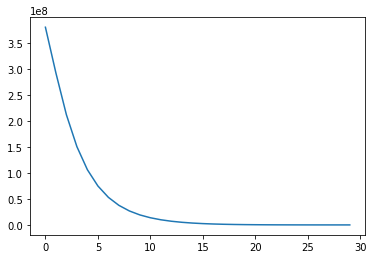

In [ ]:
usersMatrix = np.random.random((6040,18))
usersMatrix = torch.tensor(usersMatrix).to(device)
usersMatrix = torch.tensor(usersMatrix, requires_grad=True)
nb_epoch = 30
batch_size = 64
n = 6040
arrLoss = []
optim = torch.optim.Adam([usersMatrix], lr=0.01)
for i in range(nb_epoch):
    print("epoch",i)
    perm = torch.randperm(n).split(batch_size)
    tempLoss = 0
    for batch_indexes in perm:
        batchUsers = usersMatrix[batch_indexes]
        predictedRatings = batchUsers.mm(moviesMatrix)
        observedRatingsIndexes = torch.where(trueRatings[batch_indexes]>0)[0]
        optim.zero_grad()
        loss = ((predictedRatings[observedRatingsIndexes] - trueRatings_normalized[batch_indexes][observedRatingsIndexes])**2).sum()
        loss.backward()
        tempLoss += loss
        optim.step()
    arrLoss.append(tempLoss/10)
plt.plot([i for i in range(nb_epoch)],arrLoss)

In [ ]:
reconstructed_ratings_matrix = usersMatrix.mm(moviesMatrix)
print(reconstructed_ratings_matrix.shape)

torch.Size([6040, 3952])


In [ ]:
trueRatings = torch.tensor(ratingsMatrix).to(device)

In [ ]:
def precision_at_k(prediction,trueValue,k):
    cpt = 0
    for i in range(prediction.shape[0]):
        top_k_predicted = np.argsort(-1*prediction[i])[:k]
        true_top_k = np.argsort(-1*trueValue[i])[:k]
        for elt in top_k_predicted:
            if elt in true_top_k:
                cpt +=1
    return cpt/(k * prediction.shape[0])

precision_at_k(reconstructed_ratings_matrix.cpu().detach(),trueRatings.cpu(),500)

0.15120794701986756

The precision@500 on the entire dataset is around 15%

## Test on a simple case

We will create an user who loves western films and analyze the quality of the recommendations

In [ ]:
reconstructed_ratings_matrix = usersMatrix.dot(moviesMatrix.T)

In [ ]:
movies[movies["Western"] == 1]

,movie_id,title,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
208,209,Wild Bill,1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
263,265,Legends of the Fall,1994,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
300,302,"Quick and the Dead, The",1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
364,367,Maverick,1994,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
379,382,Wyatt Earp,1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,3736,Lonely Are the Brave,1962,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3723,3791,Duel in the Sun,1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3737,3805,MacKenna's Gold,1969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3801,3870,Shane,1953,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
indexesWestern = []
for i in range(len(movies[movies["Western"] == 1])):
    indexesWestern.append(movies[movies["Western"] == 1].iloc[i]["movie_id"])

In [ ]:
ratingsMatrix.shape

(6040, 3952)

In [ ]:
newUserVector = np.zeros((3952))
newUserVector2 = np.zeros((18))
for i in range(10):
    newUserVector[indexesWestern[i]] = 5
ratedIndexes = np.where(newUserVector > 0)[0]
for index in ratedIndexes:
    rating = newUserVector[index]
    movieRating = moviesMatrix[index]
    elt = rating * movieRating
    newUserVector2 += rating * movieRating
newUserVector2 /= ratedIndexes.shape[0]

In [ ]:
newUserVector2.reshape(1,-1)

array([[0. , 0. , 1.5, 0.5, 0. , 0.5, 1. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0.5, 0. , 0. , 0. , 5. ]])

In [ ]:
moviesMatrix.shape

(3952, 18)

In [ ]:
reconstructed_ratings_matrix = newUserVector2.dot(moviesMatrix.T)

In [ ]:
reconstructed_ratings_matrix.shape

(3952,)

In [ ]:
top68 = np.argsort(-1*reconstructed_ratings_matrix)[:68]

In [ ]:
cpt = 0
for index in top68:
    if (movies[movies["movie_id"] == index]["Western"].item() == 1):
        cpt += 1
print(cpt/top68.shape[0])

1.0


We created an user who only liked 10 western movies.
The recommender system recommended all the 68 western movies to this user (100% accuracy) 